In [5]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LassoLarsIC
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=2, color_codes=True,rc={'figure.figsize':(15,10)})

In [6]:
def deviance(y, pred, family):
    if family == 'gaussian':
        return np.sum((y - pred)**2)
    if family == 'binomial':
        return -2 * np.sum(y * np.log(pred) + (1-y) * np.log(1-pred))

In [7]:
_DATA_DIR = '/classes/2080001_spr2022/Data'

In [8]:
topic =  pd.read_csv('%s/Monthly_Topic_Attention_Theta.csv'%(_DATA_DIR))
topic['date'] = pd.to_datetime(topic['date'])
topic.set_index('date', inplace=True) 

macro = pd.read_csv('%s/FREDMD_20210218.csv'%(_DATA_DIR)).loc[:,['sasdate','CPIAUCSL']]
macro['sasdate'] = pd.to_datetime(macro['sasdate'])
macro.set_index('sasdate', inplace=True)
macro = macro/macro.shift(1)-1
macro.columns = ['inflation']

df = macro.join(topic).dropna()
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('&','_')
df.columns = df.columns.str.replace('/','_')
df.columns = df.columns.str.replace('-','_')
df = df.iloc[:,:-1]
df.head()

,inflation,Natural_disasters,Internet,Soft_drinks,Mobile_devices,Profits,M_A,Changes,Police_crime,Research,...,Negotiations,European_politics,Size,NASD,Mexico,Retail,Long_short_term,Wide_range,Lawsuits,UK
sasdate,,,,,,,,,,,,,,,,,,,,,
1984-01-01,0.006903,0.003393,0.001054,0.003522,0.001552,0.009622,0.004586,0.003639,0.004703,0.004628,...,0.005815,0.009105,0.003894,0.003490,0.004669,0.005357,0.004293,0.004955,0.008534,0.004675
1984-02-01,0.004897,0.004640,0.000975,0.004115,0.001611,0.008956,0.005205,0.003648,0.004393,0.004115,...,0.005541,0.007414,0.004008,0.004439,0.003033,0.004055,0.004467,0.004519,0.008337,0.004582
1984-03-01,0.002924,0.005294,0.001018,0.003355,0.001546,0.005529,0.006112,0.003461,0.004456,0.004211,...,0.005206,0.008363,0.003832,0.004134,0.003516,0.004393,0.003914,0.004839,0.009045,0.004731
1984-04-01,0.003887,0.004181,0.000927,0.003663,0.001612,0.010934,0.004572,0.003014,0.005091,0.003741,...,0.005171,0.006124,0.003205,0.003686,0.003467,0.005167,0.004159,0.004557,0.008473,0.003942
1984-05-01,0.001936,0.004179,0.001012,0.003105,0.001612,0.005622,0.004704,0.002953,0.005669,0.003715,...,0.004661,0.007005,0.003816,0.005254,0.003947,0.005518,0.004400,0.005332,0.010317,0.004083


# Full model

In [9]:
# Full model
rest_full = df.columns[1:].tolist()
rest_full = '+'.join(rest_full)

full_model = smf.glm(formula='inflation ~ {}'.format(rest_full), data = df).fit()

print(full_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              inflation   No. Observations:                  402
Model:                            GLM   Df Residuals:                      222
Model Family:                Gaussian   Df Model:                          179
Link Function:               identity   Scale:                      5.0244e-06
Method:                          IRLS   Log-Likelihood:                 2001.4
Date:                Fri, 15 Apr 2022   Deviance:                    0.0011154
Time:                        14:51:00   Pearson chi2:                  0.00112
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [10]:
# number of variables selected
N_full = len(df.columns[1:])
N_full

179

In [11]:
# Estimation and Goodness of Fit

full_R2 = 1-full_model.deviance/full_model.null_deviance
full_AIC = full_model.aic
full_BIC = full_model.bic

print("full model R2:",round(full_R2,2))
print("full model AIC:", round(full_AIC,2))
print("full model BIC:", round(full_BIC,2))

full model R2: 0.58
full model AIC: -3642.76
full model BIC: -1331.21


# Screening

In [1]:
n = df.shape[0]

# standardize
scaler = StandardScaler().fit(df) 
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled)

NameError: name 'df' is not defined

In [13]:
# compute correlation
cor = df_scaled.corr()[0][1:]

In [14]:
# Reducecd dimension
d = (cor.abs()>0.1).sum()

In [15]:
# select variables with high correlation
reduced = np.argsort(abs(cor))[df.shape[1]-d:]
reduced = list(reduced)
var_reduced = list(df.iloc[:,reduced].columns)

In [16]:
len(var_reduced) 

100

In [17]:
cor = pd.DataFrame(np.transpose(np.array([df.columns[1:],cor])))
cor.columns = ['variable','correlation']
cor = cor.sort_values(['correlation'], ascending=False).reset_index(drop=True)
cor

,variable,correlation
0,Macroeconomic_data,0.244953
1,Aerospace_defense,0.244819
2,Commodities,0.238175
3,Trading_activity,0.227117
4,Treasury_bonds,0.225543
...,...,...
174,Corrections_amplifications,-0.230138
175,Terrorism,-0.237932
176,European_sovereign_debt,-0.25834
177,Financial_crisis,-0.263844


<AxesSubplot:xlabel='correlation', ylabel='Count'>

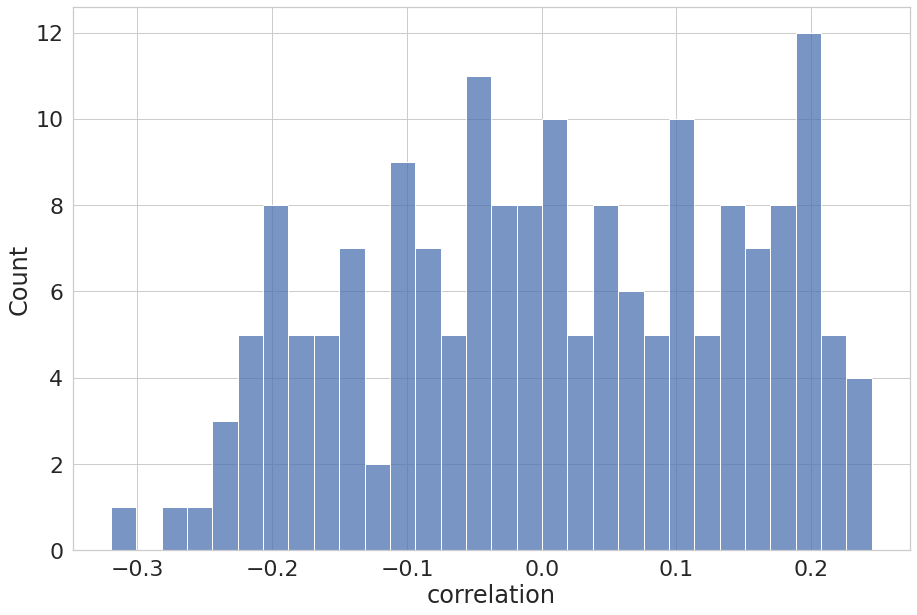

In [18]:
sns.histplot(cor.correlation,bins=30)
#plt.savefig('correlation_histogram.pdf')

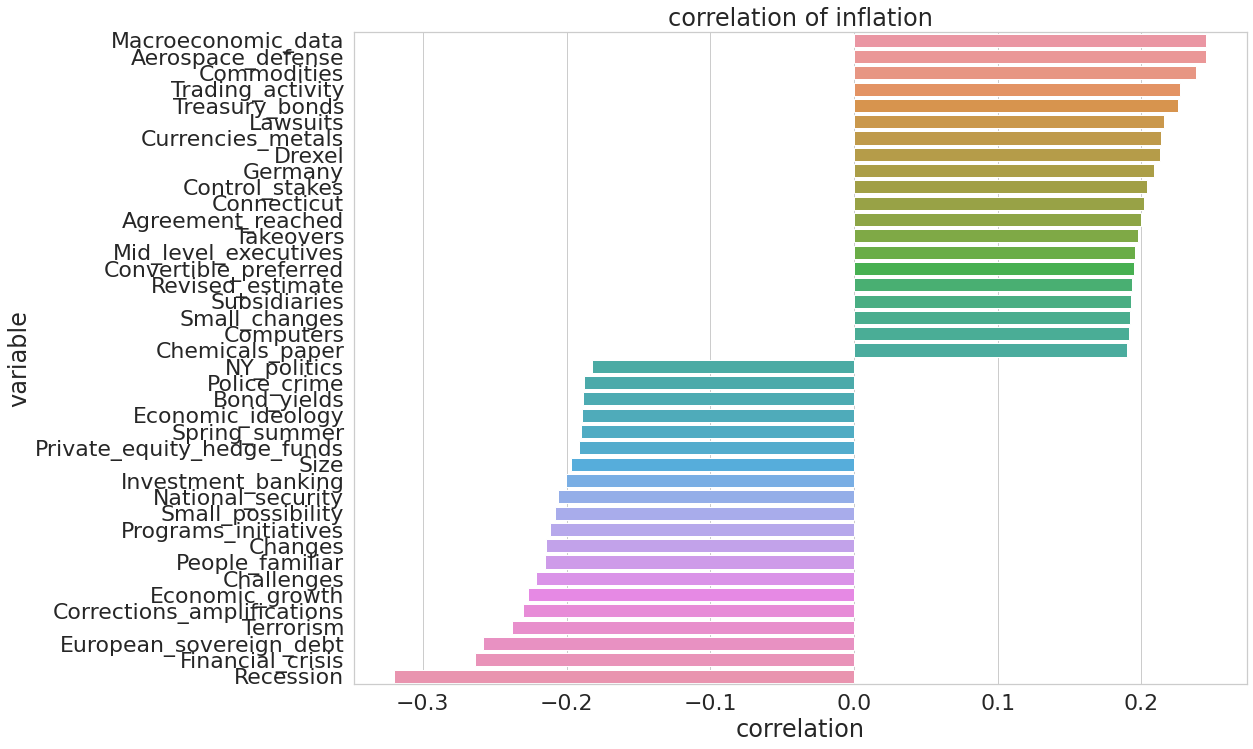

In [19]:
cor = cor.sort_values(['correlation'], ascending=False).reset_index(drop=True)
corr = cor.iloc[np.r_[0:20, -20:0]] # show first and last rows
plt.figure(figsize = (16,12))
sns.barplot(
    x="correlation", 
    y="variable", 
    data=corr, 
    estimator=sum
);
plt.title('correlation of inflation')
plt.savefig('correlation_bar.pdf')

In [20]:
# number of variables selected
N_SIS = len(var_reduced)
N_SIS

100

In [21]:
# selected variables

var_reduced

['Taxes',
 'Macroeconomic_data',
 'Japan',
 'Humor_language',
 'Insurance',
 'Lawsuits',
 'Mortgages',
 'Negotiations',
 'Utilities',
 'Casinos',
 'Tobacco',
 'Broadcasting',
 'Microchips',
 'Fast_food',
 'Small_caps',
 'Cultural_life',
 'State_politics',
 'Oil_drilling',
 'Pensions',
 'SEC',
 'Arts',
 'Unions',
 'Automotive',
 'Mobile_devices',
 'Company_spokesperson',
 'Key_role',
 'Real_estate',
 'Natural_disasters',
 'US_defense',
 'Police_crime',
 'Futures_indices',
 'Recession',
 'Short_sales',
 'Drexel',
 'Latin_America',
 'Mexico',
 'Federal_Reserve',
 'Connecticut',
 'Commodities',
 'Canada_South_Africa',
 'Mid_size_cities',
 'Safety_administrations',
 'US_Senate',
 'Corporate_governance',
 'Positive_sentiment',
 'Music_industry',
 'Reagan',
 'Germany',
 'Rental_properties',
 'France_Italy',
 'Space_program',
 'Marketing',
 'Disease',
 'Retail',
 'Soft_drinks',
 'Executive_pay',
 'Middle_east',
 'Nuclear_North_Korea',
 'Government_budgets',
 'Airlines',
 'Changes',
 'Steel',
 

In [22]:
rest_reduced  = '+'.join(var_reduced)

reduced_model = smf.glm(formula='inflation ~ {}'.format(rest_reduced), data=df).fit()

print(reduced_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              inflation   No. Observations:                  402
Model:                            GLM   Df Residuals:                      301
Model Family:                Gaussian   Df Model:                          100
Link Function:               identity   Scale:                      5.1543e-06
Method:                          IRLS   Log-Likelihood:                 1935.1
Date:                Fri, 15 Apr 2022   Deviance:                    0.0015514
Time:                        14:51:02   Pearson chi2:                  0.00155
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [23]:
# Estimation and Goodness of Fit

SIS_R2 = 1-reduced_model.deviance/reduced_model.null_deviance
SIS_AIC = reduced_model.aic
SIS_BIC = reduced_model.bic

print("SIS model R2:",round(SIS_R2,2))
print("SIS model AIC:", round(SIS_AIC,2))
print("SIS model BIC:", round(SIS_BIC,2))

SIS model R2: 0.41
SIS model AIC: -3668.11
SIS model BIC: -1804.93


In [24]:
def SIS(data, thrd):
    """
    Linear model designed by screening.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    Returns:
    --------
    model: an "optimal" fitted linear model,
           selected by sure independence screening 
    """
    
    n = df.shape[0]
    d = (cor.abs()>thrd).sum()
    scaler = StandardScaler().fit(df) 
    df_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(df_scaled)

    cor = df_scaled.corr()[0][1:]
    reduced = np.argsort(abs(cor))[df.shape[1]-d:]
    reduced = list(reduced)
    var_reduced = list(df.iloc[:,reduced].columns)

    rest_reduced  = '+'.join(var_reduced)
    reduced_model = smf.glm(formula='inflation ~ {}'.format(rest_reduced), data=df).fit()
    return reduced_model

# Forward stepwise feature selection algorithm

In [25]:
def forward_selected(data, response, Kmax):
    """
    Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response
    response: string, name of response column in data
    Kmax : max number of selected variables

    Returns:
    --------
    model: an "optimal" fitted linear model,
           selected by forward stepwise algorithm, 
           evaluated by AIC
    """
    K = 0
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = np.inf, np.inf
    while remaining and current_score == best_new_score and K <= Kmax:
        scores_with_candidates = []
        
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.glm(formula, data).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse = True)
        best_new_score, best_candidate = scores_with_candidates.pop()

        
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            K = len(selected)
            print('Add  {:30} with AIC {:.6}'.format(best_candidate, best_new_score))

            
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    print('Algorithm Finished.')
    model = smf.glm(formula, data).fit()
    return model

In [26]:
import time

start_time = time.time()

forward = forward_selected(df, response='inflation', Kmax = 100)

time = time.time() - start_time
print(time)

Add  Recession                      with AIC -3696.6
Add  Macroeconomic_data             with AIC -3707.1
Add  Natural_disasters              with AIC -3717.84
Add  NY_politics                    with AIC -3724.53
Add  Germany                        with AIC -3730.64
Add  Product_prices                 with AIC -3735.62
Add  Retail                         with AIC -3741.8
Add  Humor_language                 with AIC -3747.04
Add  Mining                         with AIC -3751.07
Add  Optimism                       with AIC -3754.7
Add  Middle_east                    with AIC -3758.51
Add  European_sovereign_debt        with AIC -3760.68
Add  Machinery                      with AIC -3762.68
Add  Sales_call                     with AIC -3766.17
Add  US_Senate                      with AIC -3769.22
Add  Problems                       with AIC -3772.78
Add  News_conference                with AIC -3774.39
Add  Challenges                     with AIC -3777.57
Add  Real_estate                

In [27]:
print(forward.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              inflation   No. Observations:                  402
Model:                            GLM   Df Residuals:                      372
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                      4.3587e-06
Method:                          IRLS   Log-Likelihood:                 1926.2
Date:                Fri, 15 Apr 2022   Deviance:                    0.0016214
Time:                        14:52:43   Pearson chi2:                  0.00162
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [28]:
# number of variables selected
N_forward = len(forward.params)-1
N_forward

29

In [29]:
# Estimation and Goodness of Fit

formward_R2 = 1-forward.deviance/forward.null_deviance
formward_AIC = forward.aic
formward_BIC = forward.bic

print("stepwise formward model R2:",round(formward_R2,2))
print("stepwise formward model AIC:", round(formward_AIC,2))
print("stepwise formward model BIC:", round(formward_BIC,2))

stepwise formward model R2: 0.38
stepwise formward model AIC: -3792.37
stepwise formward model BIC: -2230.68


In [30]:
Nvars = [N_full,N_SIS,N_forward]
R2 = [full_R2,SIS_R2,formward_R2]
AIC = [full_AIC,SIS_AIC,formward_AIC]
BIC = [full_BIC,SIS_BIC,formward_BIC]

df1 = pd.DataFrame(data = [Nvars, R2, AIC,BIC], columns= ["full", "screening", "forward"]).round(2)
df1.index = ['#variables', 'R2', 'AIC', 'BIC']
df1

,full,screening,forward
#variables,179.00,100.00,29.00
R2,0.58,0.41,0.38
AIC,-3642.76,-3668.11,-3792.37
BIC,-1331.21,-1804.93,-2230.68


# Model selection based on Lasso

In [31]:
# standardize
X = df.iloc[:,1:]
y = df[['inflation']]
Xscaler = StandardScaler().fit(X) 
yscaler = StandardScaler().fit(y) 


X_scaled = Xscaler.transform(X)
y_scaled = yscaler.transform(y)


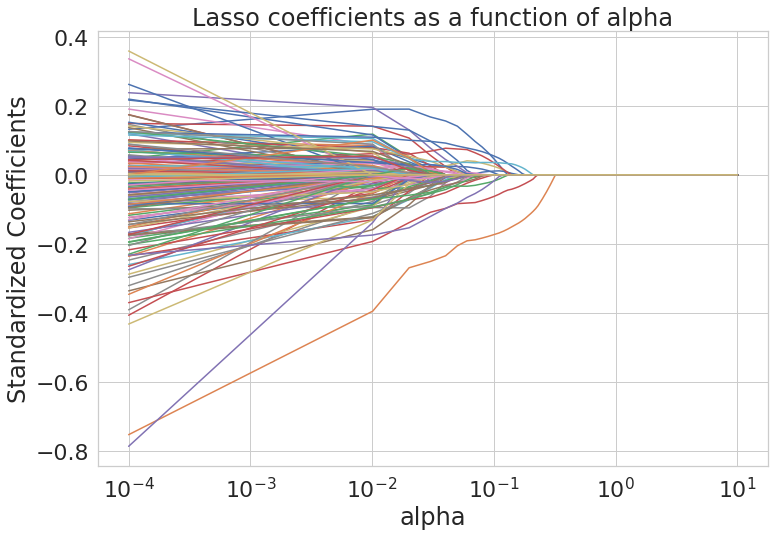

In [32]:

alphas = np.linspace(1e-4,1e+1,1000)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_scaled, y_scaled)
    coefs.append(lasso.coef_)

plt.figure(figsize = (12,8))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');
#plt.savefig('lasso_path.pdf')

In [33]:
plt.savefig('lasso_path.pdf')

<Figure size 1080x720 with 0 Axes>

## Lasso model selection based on deviance

In [34]:
model = LassoCV(cv=5, random_state = 0, max_iter=10000)
model.fit(X_scaled, y_scaled)

# Show best value of penalization chosen by CV
alpha_ = model.alpha_
print(alpha_)

# refit
model1 = lasso.set_params(alpha=alpha_).fit(X_scaled, y_scaled)

0.06888638841180296


In [35]:
# number of variables selected
N_LassoCV = (model1.coef_!=0).sum()
N_LassoCV

19

In [36]:
# selected variables
list(X.columns[model1.coef_!=0])

['Natural_disasters',
 'Disease',
 'Job_cuts',
 'Control_stakes',
 'European_sovereign_debt',
 'Private_public_sector',
 'Publishing',
 'Aerospace_defense',
 'Recession',
 'Product_prices',
 'Immigration',
 'US_Senate',
 'Agriculture',
 'Southeast_Asia',
 'Germany',
 'Utilities',
 'Macroeconomic_data',
 'National_security',
 'Retail']

In [37]:
# Estimation and Goodness of Fit
LassoCV_pred = yscaler.inverse_transform(model1.predict(X_scaled))


In [38]:
y

,inflation
sasdate,
1984-01-01,0.006903
1984-02-01,0.004897
1984-03-01,0.002924
1984-04-01,0.003887
1984-05-01,0.001936
...,...
2017-02-01,0.001276
2017-03-01,-0.001258
2017-04-01,0.001383


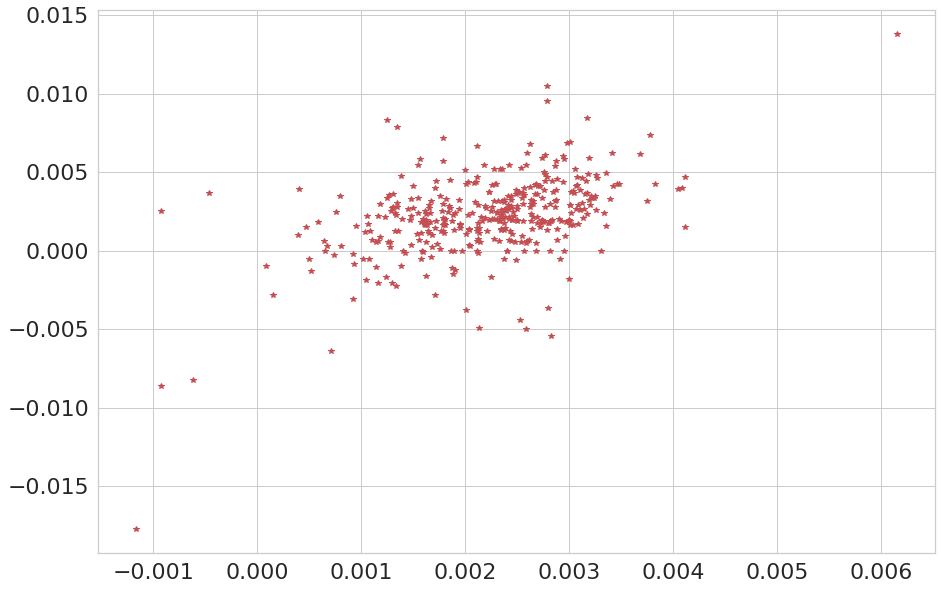

In [39]:
plt.plot(LassoCV_pred,y,'r*')

In [40]:
y.inflation

sasdate
1984-01-01    0.006903
1984-02-01    0.004897
1984-03-01    0.002924
1984-04-01    0.003887
1984-05-01    0.001936
                ...   
2017-02-01    0.001276
2017-03-01   -0.001258
2017-04-01    0.001383
2017-05-01   -0.000541
2017-06-01    0.001037
Name: inflation, Length: 402, dtype: float64

In [41]:
dev0 = deviance(y.inflation,y.inflation.mean(), family = 'gaussian')
dev = deviance(y.inflation, LassoCV_pred, family = 'gaussian')
LassoCV_R2 = 1-dev/dev0
print("LassoCV R2:",round(LassoCV_R2,2))

LassoCV R2: 0.21


## Lasso model selection based on AIC

In [42]:
model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_scaled, y_scaled)

# Show best value of penalization chosen by AIC
alpha_aic_ = model_aic.alpha_
print(alpha_aic_)

# refit
model_aic1 = lasso.set_params(alpha=alpha_aic_).fit(X_scaled, y_scaled)

0.004251441792976971


In [43]:
# number of variables selected

N_LassoAIC = (model_aic1.coef_!=0).sum()
N_LassoAIC

149

In [44]:
# selected variables

list(X.columns[model_aic1.coef_!=0])

['Natural_disasters',
 'Internet',
 'Soft_drinks',
 'Mobile_devices',
 'Profits',
 'M_A',
 'Police_crime',
 'Research',
 'Executive_pay',
 'Mid_size_cities',
 'Scenario_analysis',
 'Economic_ideology',
 'Middle_east',
 'Savings___loans',
 'IPOs',
 'Restraint',
 'Electronics',
 'Record_high',
 'Connecticut',
 'Steel',
 'Bond_yields',
 'Small_business',
 'Cable',
 'Fast_food',
 'Disease',
 'Activists',
 'Competition',
 'Short_sales',
 'Nonperforming_loans',
 'Key_role',
 'News_conference',
 'US_defense',
 'Political_contributions',
 'Economic_growth',
 'Justice_Department',
 'Credit_ratings',
 'Broadcasting',
 'Problems',
 'Announce_plan',
 'Federal_Reserve',
 'Job_cuts',
 'Chemicals_paper',
 'Small_caps',
 'Control_stakes',
 'Mutual_funds',
 'Venture_capital',
 'European_sovereign_debt',
 'Mining',
 'Company_spokesperson',
 'Private_public_sector',
 'Pharma',
 'Schools',
 'Russia',
 'Health_insurance',
 'Drexel',
 'Trade_agreements',
 'Challenges',
 'People_familiar',
 'Sales_call',
 'P

In [45]:
# Estimation and Goodness of Fit

LassoAIC_pred = yscaler.inverse_transform(model_aic1.predict(X_scaled))

dev0 = deviance(y.inflation,y.inflation.mean(), family = 'gaussian')
dev = deviance(y.inflation, LassoAIC_pred, family = 'gaussian')
LassoAIC_R2 = 1-dev/dev0

print("LassoAIC R2:",round(LassoAIC_R2,2))

LassoAIC R2: 0.54


## Lasso model selection based on BIC

In [46]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_scaled, y_scaled)

# Show best value of penalization chosen by BIC
alpha_bic_ = model_bic.alpha_
print(alpha_bic_)

# refit
model_bic1 = lasso.set_params(alpha=alpha_bic_).fit(X_scaled, y_scaled)

0.008782863914970023


In [47]:
# number of variables selected

N_LassoBIC = (model_bic1.coef_!=0).sum()
N_LassoBIC

114

In [48]:
# selected variables

list(X.columns[model_bic1.coef_!=0])

['Natural_disasters',
 'Internet',
 'Soft_drinks',
 'Mobile_devices',
 'M_A',
 'Police_crime',
 'Research',
 'Executive_pay',
 'Scenario_analysis',
 'Economic_ideology',
 'Middle_east',
 'IPOs',
 'Restraint',
 'Electronics',
 'Record_high',
 'Connecticut',
 'Steel',
 'Bond_yields',
 'Cable',
 'Fast_food',
 'Disease',
 'Activists',
 'Competition',
 'Nonperforming_loans',
 'Key_role',
 'News_conference',
 'US_defense',
 'Political_contributions',
 'Justice_Department',
 'Credit_ratings',
 'Broadcasting',
 'Problems',
 'Federal_Reserve',
 'Job_cuts',
 'Environment_',
 'Control_stakes',
 'Mutual_funds',
 'Venture_capital',
 'European_sovereign_debt',
 'Mining',
 'Company_spokesperson',
 'Private_public_sector',
 'Russia',
 'Health_insurance',
 'Trade_agreements',
 'Challenges',
 'Sales_call',
 'Publishing',
 'Aerospace_defense',
 'Recession',
 'Cultural_life',
 'SEC',
 'Computers',
 'Marketing',
 'Nuclear_North_Korea',
 'NY_politics',
 'Tobacco',
 'Product_prices',
 'Movie_industry',
 'Aut

In [49]:
# Estimation and Goodness of Fit

LassoBIC_pred = yscaler.inverse_transform(model_bic1.predict(X_scaled))

dev0 = deviance(y.inflation,y.inflation.mean(), family = 'gaussian')
dev = deviance(y.inflation, LassoBIC_pred, family = 'gaussian')
LassoBIC_R2 = 1-dev/dev0

print("LassoBIC R2:",round(LassoBIC_R2,2))

LassoBIC R2: 0.49


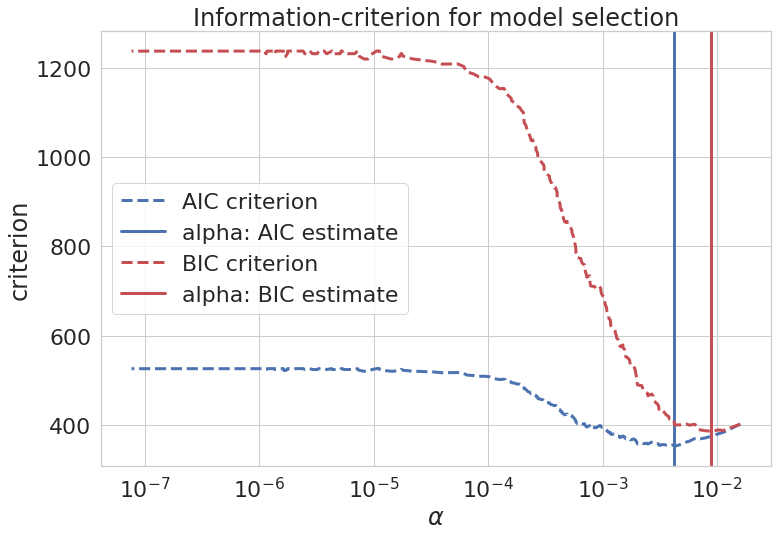

In [50]:
from matplotlib.ticker import ScalarFormatter
def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')

plt.figure(figsize = (12,8))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()

plt.title('Information-criterion for model selection')

plt.savefig('lasso_aicbic.pdf')

Text(0, 0.5, 'mean squared error')

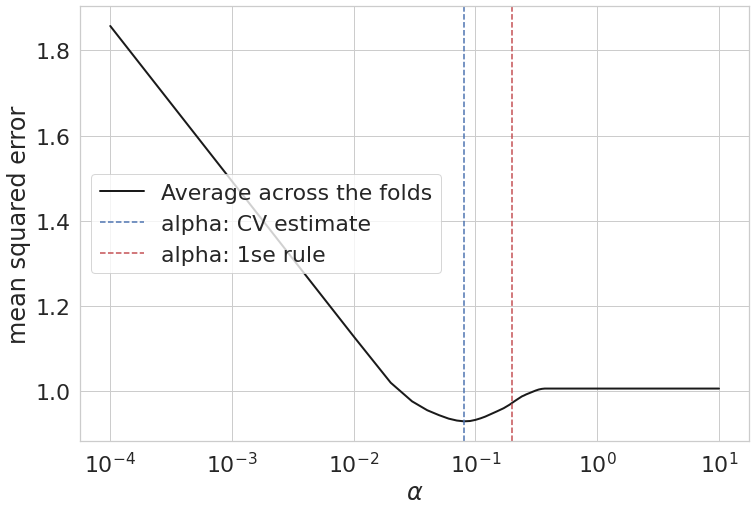

In [51]:
from sklearn.model_selection import RepeatedKFold
cva = RepeatedKFold(n_splits=5,n_repeats = 10, random_state=42)
model = LassoCV(cv=cva,alphas = np.linspace(1e-4,1e+1,1000),random_state = 1000, max_iter=10000,selection='random')
model.fit(X_scaled, y_scaled)

alpha_ = model.alpha_

alpha = list(model.alphas_).index(model.alpha_)

mse_1se = np.std(model.mse_path_[alpha])/np.sqrt(len(model.mse_path_[alpha]))+np.mean(model.mse_path_[alpha])
i = alpha
for i in range(alpha,0,-1):
    if np.mean(model.mse_path_[i-1]) > mse_1se:
        break
        
plt.figure(figsize = (12,8))
plt.semilogx(model.alphas_ , model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_, linestyle='--', color='b',
            label='alpha: CV estimate')
plt.axvline(model.alphas_[i], linestyle='--', color='r',
            label='alpha: 1se rule')
plt.legend()

 

plt.xlabel(r'$\alpha$')
plt.ylabel('mean squared error')

In [52]:
plt.savefig('lasso_mse.pdf')

<Figure size 1080x720 with 0 Axes>